https://www.kaggle.com/code/captaingaga/water-quality-70-acc-optuna-svm-iterativeimputer/notebook
https://www.kaggle.com/code/muhammetgamal5/kfold-cross-validation-optuna-tuning/notebook
https://www.kaggle.com/code/neilgibbons/tuning-tabnet-with-optuna
    

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from warnings import simplefilter
simplefilter("ignore", category=RuntimeWarning)

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# load models
import xgboost
from xgboost import XGBClassifier

import sklearn.svm
from sklearn.svm import SVC

from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetClassifier

In [3]:
# Set working directory
os.chdir("C:\\Users\Mumtaz\Desktop\Thesis data")

In [4]:
# load data
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv') 

In [5]:
# Check the target variable
df['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [6]:
# Convert to right types
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['SeniorCitizen'] = df['SeniorCitizen'].map({1: 'Yes', 0: 'No'})

In [7]:
# replace missing values with median
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

In [8]:
#drop column customerID, this is not relevant
df.drop(columns=['customerID'], inplace = True)

In [9]:
# transform to binary
df['gender'].replace({'Female':1,'Male':0},inplace=True)

In [10]:
# simplify value
df.replace('No internet service', 'No', inplace=True)
df.replace('No phone service', 'No', inplace=True)

In [11]:
# get dummies for features with multiple categories
multiple_categories = ['InternetService' ,'Contract' ,'PaymentMethod']
df = pd.get_dummies(data=df, columns= multiple_categories)

In [12]:
# encode binary values
categories = df[['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup','DeviceProtection','TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']]
for i in categories:
    df[i].replace({"No":0, "Yes":1}, inplace=True)

In [13]:
# split data into features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

In [14]:
# split the data with stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2, random_state=42)

In [15]:
# scale numeric values
from sklearn.preprocessing import StandardScaler
X_train[['tenure', 'MonthlyCharges', 'TotalCharges']] = StandardScaler().fit_transform(X_train[['tenure', 'MonthlyCharges', 'TotalCharges']])
X_test[['tenure', 'MonthlyCharges', 'TotalCharges']] = StandardScaler().fit_transform(X_test[['tenure', 'MonthlyCharges', 'TotalCharges']])

In [16]:
# Smote for training set
from imblearn.over_sampling import KMeansSMOTE
from sklearn.cluster import MiniBatchKMeans
for label, count in zip(*np.unique(y_train, return_counts=True)):
    print('Class {} has {} samples'.format(label, count))

kmeans_smote = KMeansSMOTE(
    sampling_strategy = 'not majority',
    random_state = 42,
    k_neighbors = 10,
    cluster_balance_threshold = 0.1,
    kmeans_estimator = MiniBatchKMeans(n_clusters=100, random_state=42)
)
X_train, y_train = kmeans_smote.fit_resample(X_train, y_train)

for label, count in zip(*np.unique(y_train, return_counts=True)):
    print('Class {} has {} samples after oversampling'.format(label, count))

Class 0 has 4139 samples
Class 1 has 1495 samples


C:\Users\Mumtaz\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Class 0 has 4139 samples after oversampling
Class 1 has 4162 samples after oversampling


In [17]:
# Check the target variable
y_train.value_counts()

1    4162
0    4139
Name: Churn, dtype: int64

In [18]:
print(f"X_train shape :{X_train.shape}, y_train shape: {y_train.shape}")

X_train shape :(8301, 26), y_train shape: (8301,)


In [19]:
X_train = X_train.rename(columns={'InternetService_Fiber optic': 'InternetService_Fiber_optic', 'Contract_One year' : 'Contract_One_year', 'Contract_Two year': 'Contract_Two_year',
                      'PaymentMethod_Bank transfer (automatic)':'PaymentMethod_Bank_transfer_automatic', 'PaymentMethod_Credit card (automatic)':'PaymentMethod_Creditcard_automatic)',
                      'PaymentMethod_Electronic check': 'PaymentMethod_Electronic_check', 'PaymentMethod_Mailed check': 'PaymentMethod_Mailed_check'})

In [20]:
X_test = X_test.rename(columns={'InternetService_Fiber optic': 'InternetService_Fiber_optic', 'Contract_One year' : 'Contract_One_year', 'Contract_Two year': 'Contract_Two_year',
                      'PaymentMethod_Bank transfer (automatic)':'PaymentMethod_Bank_transfer_automatic', 'PaymentMethod_Credit card (automatic)':'PaymentMethod_Creditcard_automatic)',
                      'PaymentMethod_Electronic check': 'PaymentMethod_Electronic_check', 'PaymentMethod_Mailed check': 'PaymentMethod_Mailed_check'})

# XGBOOST

In [81]:
import optuna
def xgb_optimize(trial):
    #split data for training and validation
    X_tr, X_valid, y_tr, y_valid = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2,random_state=42)
 
    n_estimators = trial.suggest_int("n_estimators",500,2500)
    max_depth = trial.suggest_int("max_depth",10,25)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.5)
    gamma = trial.suggest_float("gamma", 0.05, 0.8)
    subsample = trial.suggest_float("subsample", 0.5, 0.8)
    min_child_weight = trial.suggest_float("min_child_weight", 0.5, 3)
    reg_lambda = trial.suggest_float("reg_lambda", 1.3, 2.3)
    reg_alpha = trial.suggest_float("reg_alpha", 1.5, 2.2)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.25, 0.8)
    xgb_params = dict(use_label_encoder=False,
                  n_estimators = n_estimators,
                  max_depth = max_depth,
                  learning_rate = learning_rate,
                  gamma = gamma,
                  subsample = subsample,
                  min_child_weight = min_child_weight,
                  reg_lambda = reg_lambda,
                  reg_alpha = reg_alpha,                  
                  colsample_bytree = colsample_bytree,
                  random_state=42,
                  verbosity=0,    
                      )  
    xgb_model = XGBClassifier(**xgb_params)
    xgb_model.fit(X_tr, y_tr,
                  eval_set=[(X_valid, y_valid)], verbose=0)
    y_pred = xgb_model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)

    return accuracy

In [82]:
study = optuna.create_study(direction="maximize", study_name='XGB optimization')
study.optimize(xgb_optimize, n_trials=100)

[I 2023-05-19 11:46:51,076] A new study created in memory with name: XGB optimization
[I 2023-05-19 11:47:02,744] Trial 0 finished with value: 0.839855508729681 and parameters: {'n_estimators': 1357, 'max_depth': 14, 'learning_rate': 0.2725030718246668, 'gamma': 0.4642119456188759, 'subsample': 0.538366430844113, 'min_child_weight': 0.5950827794131035, 'reg_lambda': 2.0536861736474172, 'reg_alpha': 1.939428573667716, 'colsample_bytree': 0.3361207309401514}. Best is trial 0 with value: 0.839855508729681.
[I 2023-05-19 11:47:21,827] Trial 1 finished with value: 0.8452739313666466 and parameters: {'n_estimators': 1719, 'max_depth': 19, 'learning_rate': 0.4143338152561965, 'gamma': 0.23046068730153096, 'subsample': 0.5140786525671873, 'min_child_weight': 1.7960195826013974, 'reg_lambda': 1.7211256738600005, 'reg_alpha': 2.021192214566036, 'colsample_bytree': 0.7185499534174586}. Best is trial 1 with value: 0.8452739313666466.
[I 2023-05-19 11:47:53,128] Trial 2 finished with value: 0.84888

In [83]:
XGBoost_params = study.best_params
print(XGBoost_params)

{'n_estimators': 1986, 'max_depth': 13, 'learning_rate': 0.044627773598530054, 'gamma': 0.280206721005955, 'subsample': 0.58545974420027, 'min_child_weight': 2.3451283944922916, 'reg_lambda': 1.9688536003000663, 'reg_alpha': 1.6563747476472204, 'colsample_bytree': 0.7486193155195076}


In [84]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
XGBOOST_model = XGBClassifier(**XGBoost_params)
kfold_val = KFold(10, shuffle=True, random_state=42)
cv_score = cross_val_score(XGBOOST_model, X_train, y_train, cv=kfold_val, verbose=1)
print(cv_score)
print("%0.2f accuracy with a standard deviation of %0.2f" % (cv_score.mean(), cv_score.std()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[0.85920578 0.82771084 0.85542169 0.84216867 0.86385542 0.84819277
 0.87710843 0.86024096 0.84337349 0.82650602]
0.85 accuracy with a standard deviation of 0.02


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.0min finished


In [85]:
import time
final_xgb_model = XGBClassifier(**XGBoost_params)
xgb_train_start = time.perf_counter()
final_xgb_model.fit(X_train, y_train)
xgb_train_end = time.perf_counter()

xgb_pred_start = time.perf_counter()
final_xgb_preds = final_xgb_model.predict(X_test)
xgb_pred_end = time.perf_counter()

xgb_train_time = xgb_train_end-xgb_train_start
xgb_pred_time = xgb_pred_end-xgb_pred_start

print("Time consumed for training:" ,xgb_train_time, "seconds")
print("Time consumed for prediction:" ,xgb_pred_time, "seconds")

Time consumed for training: 40.69587049999973 seconds
Time consumed for prediction: 0.11860039999010041 seconds


In [86]:
from sklearn.metrics import classification_report
print(classification_report(y_test, final_xgb_preds))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1035
           1       0.52      0.74      0.61       374

    accuracy                           0.75      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.75      0.76      1409



In [89]:
final_xgb_model = XGBClassifier(**XGBoost_params)
xgb_train_start = time.perf_counter()
final_xgb_model.fit(X_train, y_train)
xgb_train_end = time.perf_counter()

xgb_pred_start = time.perf_counter()
final_xgb_preds_proba = final_xgb_model.predict_proba(X_test)[:,1]
xgb_pred_end = time.perf_counter()

xgb_train_time = xgb_train_end-xgb_train_start
xgb_pred_time = xgb_pred_end-xgb_pred_start

print("Time consumed for training:" ,xgb_train_time, "seconds")
print("Time consumed for prediction:" ,xgb_pred_time, "seconds")

Time consumed for training: 37.22600679998868 seconds
Time consumed for prediction: 0.11597270000493154 seconds


In [92]:
xgb_score=roc_auc_score(y_test, final_xgb_preds_proba)
print("The ROC AUC score is" ,xgb_score)

The ROC AUC score is 0.8232555736392054


# SVM CLASSIFIER

In [32]:
def svm_optimize(trial):
    
    X_tr, X_test, y_tr, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2,random_state=42)
    
    C = trial.suggest_categorical("C",[0.1, 1, 10, 100])
    gamma = trial.suggest_categorical("gamma",[1, 0.1, 0.01, 0.001, 0.0001])
    kernel = trial.suggest_categorical('kernel',['rbf','linear', 'poly'])
    svm_params = dict(C = C,
                  gamma = gamma,
                  kernel = kernel,
                  random_state=42,
                  verbose=False,  
                     )  
    svm_model = SVC(**svm_params)
    svm_model.fit(X_tr, y_tr)
    y_pred = svm_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [33]:
svm_study = optuna.create_study(direction="maximize", study_name='SVM optimization')
svm_study.optimize(svm_optimize, n_trials=100)

[I 2023-05-17 18:04:27,108] A new study created in memory with name: SVM optimization
[I 2023-05-17 18:04:32,824] Trial 0 finished with value: 0.8567128236002408 and parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}. Best is trial 0 with value: 0.8567128236002408.
[I 2023-05-17 18:04:39,816] Trial 1 finished with value: 0.8446718844069837 and parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}. Best is trial 0 with value: 0.8567128236002408.
[I 2023-05-17 18:04:44,604] Trial 2 finished with value: 0.5015051173991572 and parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}. Best is trial 0 with value: 0.8567128236002408.
[I 2023-05-17 18:04:48,441] Trial 3 finished with value: 0.8061408789885611 and parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}. Best is trial 0 with value: 0.8567128236002408.
[I 2023-05-17 18:04:54,267] Trial 4 finished with value: 0.769416014449127 and parameters: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}. Best is trial 0 with value: 0.8567128236002408.
[I 20

In [35]:
SVC_params = svm_study.best_params
print(SVC_params)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [39]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
SVM_model = SVC(**SVC_params)
kfold_val = KFold(10, shuffle=True, random_state=42)
cv_score = cross_val_score(SVM_model, X_train, y_train, cv=kfold_val, verbose=1)
print(cv_score)
print("%0.2f accuracy with a standard deviation of %0.2f" % (cv_score.mean(), cv_score.std()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[0.86762936 0.83253012 0.85301205 0.8373494  0.8626506  0.84698795
 0.88192771 0.86626506 0.84457831 0.82891566]
0.85 accuracy with a standard deviation of 0.02


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished


In [40]:
import time
final_svm_model = SVC(**SVC_params)
svm_train_start = time.perf_counter()
final_svm_model.fit(X_train, y_train)
svm_train_end = time.perf_counter()

svm_pred_start = time.perf_counter()
final_svm_preds = final_svm_model.predict(X_test)
svm_pred_end = time.perf_counter()

svm_train_time = svm_train_end-svm_train_start
svm_pred_time = svm_pred_end-svm_pred_start

print("Time consumed for training:" ,svm_train_time, "seconds")
print("Time consumed for prediction:" ,svm_pred_time, "seconds")

Time consumed for training: 8.903808300000037 seconds
Time consumed for prediction: 2.1705918000002384 seconds


In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test, final_svm_preds))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1035
           1       0.57      0.58      0.58       374

    accuracy                           0.77      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.77      0.77      0.77      1409



In [94]:
final_svm_model = SVC(**SVC_params, probability=True)
svm_train_start = time.perf_counter()
final_svm_model.fit(X_train, y_train)
svm_train_end = time.perf_counter()

svm_pred_start = time.perf_counter()
final_svm_preds_proba = final_svm_model.predict_proba(X_test)[:,1]
svm_pred_end = time.perf_counter()

svm_train_time = svm_train_end-svm_train_start
svm_pred_time = svm_pred_end-svm_pred_start

print("Time consumed for training:" ,svm_train_time, "seconds")
print("Time consumed for prediction:" ,svm_pred_time, "seconds")

Time consumed for training: 37.57071880000876 seconds
Time consumed for prediction: 1.4201552999729756 seconds


In [95]:
svm_score=roc_auc_score(y_test, final_svm_preds_proba)
print("The ROC AUC score is" ,svm_score)

The ROC AUC score is 0.7831783306207858


# TabNet pre-trainer & classifier

In [51]:
#transform data to numpy arrays for Pytorch (since it only deals with tensors)
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy().squeeze()
X_test_np  = X_test.to_numpy()
y_test_np = y_test.to_numpy().squeeze()

In [54]:
# hyperparameter tuning for the TabNet classifier (without pre-training)
def tabnetclf_optimize(trial):
    #split data for training and validation
    X_tr, X_valid, y_tr, y_valid = train_test_split(X_train_np, y_train_np, stratify=y_train_np, test_size=0.2,random_state=42)
 
    mask_type = trial.suggest_categorical("mask_type", ["entmax", "sparsemax"])
    n_da = trial.suggest_int("n_da", 56, 64, step=4)
    n_steps = trial.suggest_int("n_steps", 1, 3, step=1)
    gamma = trial.suggest_float("gamma", 1., 1.4, step=0.2)
    n_shared = trial.suggest_int("n_shared", 1, 3)
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True)
    tabnet_params = dict(n_d=n_da, n_a=n_da, n_steps=n_steps, gamma=gamma,
                     lambda_sparse=lambda_sparse, optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                     mask_type=mask_type, n_shared=n_shared,
                     scheduler_params=dict(mode="min",
                                           patience=trial.suggest_int("patienceScheduler",low=3,high=10), # changing sheduler patience to be lower than early stopping patience 
                                           min_lr=1e-5,
                                           factor=0.5,),   
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     verbose=0,
                     ) #early stopping
    tabnet_clf = TabNetClassifier(**tabnet_params)
    tabnet_clf.fit(X_tr, y_tr,
                  eval_set=[(X_valid, y_valid)], 
                  patience=trial.suggest_int("patience",low=15,high=30), max_epochs=trial.suggest_int('epochs', 1, 100)
                  )
    y_pred = tabnet_clf.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)

    return accuracy

In [55]:
tabnetclf_study = optuna.create_study(direction="maximize", study_name='TabNet Classifier optimization')
tabnetclf_study.optimize(tabnetclf_optimize, n_trials=100)

[I 2023-05-17 20:23:40,400] A new study created in memory with name: TabNet Classifier optimization


Stop training because you reached max_epochs = 65 with best_epoch = 61 and best_val_0_auc = 0.90028


[I 2023-05-17 20:28:58,792] Trial 0 finished with value: 0.8211920529801324 and parameters: {'mask_type': 'entmax', 'n_da': 60, 'n_steps': 2, 'gamma': 1.2, 'n_shared': 1, 'lambda_sparse': 0.0001102604429448004, 'patienceScheduler': 8, 'patience': 18, 'epochs': 65}. Best is trial 0 with value: 0.8211920529801324.



Early stopping occurred at epoch 59 with best_epoch = 38 and best_val_0_auc = 0.89083


[I 2023-05-17 20:35:46,798] Trial 1 finished with value: 0.8133654425045154 and parameters: {'mask_type': 'entmax', 'n_da': 60, 'n_steps': 2, 'gamma': 1.2, 'n_shared': 2, 'lambda_sparse': 1.4916983515434773e-05, 'patienceScheduler': 6, 'patience': 21, 'epochs': 87}. Best is trial 0 with value: 0.8211920529801324.


Stop training because you reached max_epochs = 53 with best_epoch = 36 and best_val_0_auc = 0.88227


[I 2023-05-17 20:42:45,433] Trial 2 finished with value: 0.8151715833835039 and parameters: {'mask_type': 'entmax', 'n_da': 56, 'n_steps': 3, 'gamma': 1.0, 'n_shared': 2, 'lambda_sparse': 3.8872519945327864e-06, 'patienceScheduler': 10, 'patience': 29, 'epochs': 53}. Best is trial 0 with value: 0.8211920529801324.


Stop training because you reached max_epochs = 32 with best_epoch = 28 and best_val_0_auc = 0.8925


[I 2023-05-17 20:46:23,118] Trial 3 finished with value: 0.8217940999397954 and parameters: {'mask_type': 'entmax', 'n_da': 60, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 2, 'lambda_sparse': 9.39991900897581e-05, 'patienceScheduler': 9, 'patience': 29, 'epochs': 32}. Best is trial 3 with value: 0.8217940999397954.


Stop training because you reached max_epochs = 23 with best_epoch = 22 and best_val_0_auc = 0.88536


[I 2023-05-17 20:48:13,993] Trial 4 finished with value: 0.7591812161348586 and parameters: {'mask_type': 'entmax', 'n_da': 60, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 8.916917095277511e-06, 'patienceScheduler': 10, 'patience': 17, 'epochs': 23}. Best is trial 3 with value: 0.8217940999397954.


Stop training because you reached max_epochs = 24 with best_epoch = 23 and best_val_0_auc = 0.87568


[I 2023-05-17 20:49:57,086] Trial 5 finished with value: 0.786273329319687 and parameters: {'mask_type': 'entmax', 'n_da': 56, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.00018237160112225656, 'patienceScheduler': 3, 'patience': 20, 'epochs': 24}. Best is trial 3 with value: 0.8217940999397954.


Stop training because you reached max_epochs = 29 with best_epoch = 28 and best_val_0_auc = 0.89515


[I 2023-05-17 20:53:19,788] Trial 6 finished with value: 0.8097531607465382 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 1, 'gamma': 1.4, 'n_shared': 3, 'lambda_sparse': 3.754977413270747e-06, 'patienceScheduler': 7, 'patience': 21, 'epochs': 29}. Best is trial 3 with value: 0.8217940999397954.


Stop training because you reached max_epochs = 56 with best_epoch = 55 and best_val_0_auc = 0.89339


[I 2023-05-17 21:00:35,497] Trial 7 finished with value: 0.839855508729681 and parameters: {'mask_type': 'sparsemax', 'n_da': 56, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 3, 'lambda_sparse': 1.0407738553391191e-06, 'patienceScheduler': 6, 'patience': 21, 'epochs': 56}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 12 with best_epoch = 11 and best_val_0_auc = 0.8756


[I 2023-05-17 21:02:15,261] Trial 8 finished with value: 0.7838651414810355 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 3, 'gamma': 1.2, 'n_shared': 1, 'lambda_sparse': 2.5623227631264605e-05, 'patienceScheduler': 8, 'patience': 26, 'epochs': 12}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 11 with best_epoch = 10 and best_val_0_auc = 0.85407


[I 2023-05-17 21:03:20,974] Trial 9 finished with value: 0.7435279951836243 and parameters: {'mask_type': 'entmax', 'n_da': 56, 'n_steps': 3, 'gamma': 1.0, 'n_shared': 1, 'lambda_sparse': 0.00023109358880649063, 'patienceScheduler': 7, 'patience': 21, 'epochs': 11}. Best is trial 7 with value: 0.839855508729681.



Early stopping occurred at epoch 66 with best_epoch = 42 and best_val_0_auc = 0.88335


[I 2023-05-17 21:09:04,102] Trial 10 finished with value: 0.8121613485851896 and parameters: {'mask_type': 'sparsemax', 'n_da': 56, 'n_steps': 1, 'gamma': 1.4, 'n_shared': 3, 'lambda_sparse': 1.45974590919587e-06, 'patienceScheduler': 4, 'patience': 24, 'epochs': 95}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 46 with best_epoch = 45 and best_val_0_auc = 0.8892


[I 2023-05-17 21:13:47,780] Trial 11 finished with value: 0.8223961468994582 and parameters: {'mask_type': 'sparsemax', 'n_da': 60, 'n_steps': 1, 'gamma': 1.4, 'n_shared': 3, 'lambda_sparse': 5.965307892496747e-05, 'patienceScheduler': 5, 'patience': 30, 'epochs': 46}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 63 with best_epoch = 55 and best_val_0_auc = 0.89934


[I 2023-05-17 21:21:36,741] Trial 12 finished with value: 0.8296207104154124 and parameters: {'mask_type': 'sparsemax', 'n_da': 64, 'n_steps': 1, 'gamma': 1.4, 'n_shared': 3, 'lambda_sparse': 0.0008450656123920122, 'patienceScheduler': 5, 'patience': 15, 'epochs': 63}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 72 with best_epoch = 69 and best_val_0_auc = 0.90555


[I 2023-05-17 21:30:30,734] Trial 13 finished with value: 0.839855508729681 and parameters: {'mask_type': 'sparsemax', 'n_da': 64, 'n_steps': 1, 'gamma': 1.2, 'n_shared': 3, 'lambda_sparse': 0.0008133167414508282, 'patienceScheduler': 5, 'patience': 16, 'epochs': 72}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 78 with best_epoch = 76 and best_val_0_auc = 0.89878


[I 2023-05-17 21:39:39,354] Trial 14 finished with value: 0.8266104756170981 and parameters: {'mask_type': 'sparsemax', 'n_da': 64, 'n_steps': 1, 'gamma': 1.2, 'n_shared': 3, 'lambda_sparse': 0.0008257042692257533, 'patienceScheduler': 5, 'patience': 15, 'epochs': 78}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 69 with best_epoch = 56 and best_val_0_auc = 0.8869


[I 2023-05-17 21:45:31,179] Trial 15 finished with value: 0.818783865141481 and parameters: {'mask_type': 'sparsemax', 'n_da': 56, 'n_steps': 1, 'gamma': 1.0, 'n_shared': 3, 'lambda_sparse': 1.5091666381748113e-06, 'patienceScheduler': 6, 'patience': 24, 'epochs': 69}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 48 with best_epoch = 39 and best_val_0_auc = 0.87794


[I 2023-05-17 21:54:01,789] Trial 16 finished with value: 0.8097531607465382 and parameters: {'mask_type': 'sparsemax', 'n_da': 64, 'n_steps': 3, 'gamma': 1.2, 'n_shared': 2, 'lambda_sparse': 0.00046138874967228564, 'patienceScheduler': 3, 'patience': 18, 'epochs': 48}. Best is trial 7 with value: 0.839855508729681.



Early stopping occurred at epoch 66 with best_epoch = 49 and best_val_0_auc = 0.88746


[I 2023-05-17 22:03:58,678] Trial 17 finished with value: 0.8260084286574353 and parameters: {'mask_type': 'sparsemax', 'n_da': 60, 'n_steps': 2, 'gamma': 1.2, 'n_shared': 3, 'lambda_sparse': 3.4300136083954666e-05, 'patienceScheduler': 4, 'patience': 17, 'epochs': 82}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 98 with best_epoch = 75 and best_val_0_auc = 0.89868


[I 2023-05-17 22:14:29,670] Trial 18 finished with value: 0.8326309452137267 and parameters: {'mask_type': 'sparsemax', 'n_da': 56, 'n_steps': 2, 'gamma': 1.0, 'n_shared': 2, 'lambda_sparse': 5.230708616293855e-06, 'patienceScheduler': 6, 'patience': 24, 'epochs': 98}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 40 with best_epoch = 39 and best_val_0_auc = 0.90202


[I 2023-05-17 22:19:26,522] Trial 19 finished with value: 0.8254063816977725 and parameters: {'mask_type': 'sparsemax', 'n_da': 64, 'n_steps': 1, 'gamma': 1.2, 'n_shared': 3, 'lambda_sparse': 0.00035836171034973137, 'patienceScheduler': 4, 'patience': 19, 'epochs': 40}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 73 with best_epoch = 58 and best_val_0_auc = 0.89831


[I 2023-05-17 22:31:01,937] Trial 20 finished with value: 0.839253461770018 and parameters: {'mask_type': 'sparsemax', 'n_da': 60, 'n_steps': 3, 'gamma': 1.2, 'n_shared': 2, 'lambda_sparse': 1.078399944683293e-06, 'patienceScheduler': 8, 'patience': 26, 'epochs': 73}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 72 with best_epoch = 60 and best_val_0_auc = 0.90304


[I 2023-05-17 22:42:28,074] Trial 21 finished with value: 0.8350391330523781 and parameters: {'mask_type': 'sparsemax', 'n_da': 60, 'n_steps': 3, 'gamma': 1.2, 'n_shared': 2, 'lambda_sparse': 1.0182525191791336e-06, 'patienceScheduler': 8, 'patience': 27, 'epochs': 72}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 60 with best_epoch = 46 and best_val_0_auc = 0.892


[I 2023-05-17 22:53:51,496] Trial 22 finished with value: 0.8091511137868754 and parameters: {'mask_type': 'sparsemax', 'n_da': 64, 'n_steps': 3, 'gamma': 1.2, 'n_shared': 2, 'lambda_sparse': 2.306135961223143e-06, 'patienceScheduler': 7, 'patience': 26, 'epochs': 60}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 58 with best_epoch = 37 and best_val_0_auc = 0.88503


[I 2023-05-17 23:02:08,581] Trial 23 finished with value: 0.8181818181818182 and parameters: {'mask_type': 'sparsemax', 'n_da': 56, 'n_steps': 3, 'gamma': 1.2, 'n_shared': 2, 'lambda_sparse': 8.833359280131194e-06, 'patienceScheduler': 9, 'patience': 23, 'epochs': 58}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 75 with best_epoch = 67 and best_val_0_auc = 0.89034


[I 2023-05-17 23:13:46,668] Trial 24 finished with value: 0.8175797712221553 and parameters: {'mask_type': 'sparsemax', 'n_da': 60, 'n_steps': 2, 'gamma': 1.2, 'n_shared': 3, 'lambda_sparse': 2.326200950619963e-06, 'patienceScheduler': 5, 'patience': 26, 'epochs': 75}. Best is trial 7 with value: 0.839855508729681.



Early stopping occurred at epoch 85 with best_epoch = 63 and best_val_0_auc = 0.88439


[I 2023-05-17 23:24:02,741] Trial 25 finished with value: 0.8193859121011439 and parameters: {'mask_type': 'sparsemax', 'n_da': 60, 'n_steps': 2, 'gamma': 1.0, 'n_shared': 2, 'lambda_sparse': 1.0947804984458268e-06, 'patienceScheduler': 6, 'patience': 22, 'epochs': 89}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 41 with best_epoch = 40 and best_val_0_auc = 0.87555


[I 2023-05-17 23:28:08,968] Trial 26 finished with value: 0.8037326911499096 and parameters: {'mask_type': 'sparsemax', 'n_da': 60, 'n_steps': 1, 'gamma': 1.2, 'n_shared': 3, 'lambda_sparse': 2.132826720187145e-06, 'patienceScheduler': 9, 'patience': 16, 'epochs': 41}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 53 with best_epoch = 52 and best_val_0_auc = 0.88791


[I 2023-05-17 23:37:09,871] Trial 27 finished with value: 0.8211920529801324 and parameters: {'mask_type': 'sparsemax', 'n_da': 56, 'n_steps': 3, 'gamma': 1.4, 'n_shared': 3, 'lambda_sparse': 1.7273922936727114e-05, 'patienceScheduler': 7, 'patience': 19, 'epochs': 53}. Best is trial 7 with value: 0.839855508729681.



Early stopping occurred at epoch 73 with best_epoch = 45 and best_val_0_auc = 0.89736


[I 2023-05-17 23:46:59,409] Trial 28 finished with value: 0.8296207104154124 and parameters: {'mask_type': 'sparsemax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 2, 'lambda_sparse': 6.273149103288931e-06, 'patienceScheduler': 8, 'patience': 28, 'epochs': 81}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 65 with best_epoch = 56 and best_val_0_auc = 0.89118


[I 2023-05-17 23:56:18,401] Trial 29 finished with value: 0.8302227573750752 and parameters: {'mask_type': 'sparsemax', 'n_da': 60, 'n_steps': 2, 'gamma': 1.2, 'n_shared': 3, 'lambda_sparse': 3.476762010511439e-05, 'patienceScheduler': 6, 'patience': 25, 'epochs': 65}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 68 with best_epoch = 66 and best_val_0_auc = 0.89631


[I 2023-05-18 00:00:58,762] Trial 30 finished with value: 0.8308248043347382 and parameters: {'mask_type': 'sparsemax', 'n_da': 56, 'n_steps': 1, 'gamma': 1.0, 'n_shared': 2, 'lambda_sparse': 6.184646019755498e-05, 'patienceScheduler': 4, 'patience': 23, 'epochs': 68}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 73 with best_epoch = 71 and best_val_0_auc = 0.89843


[I 2023-05-18 00:11:54,101] Trial 31 finished with value: 0.8266104756170981 and parameters: {'mask_type': 'sparsemax', 'n_da': 60, 'n_steps': 3, 'gamma': 1.2, 'n_shared': 2, 'lambda_sparse': 1.2706623747226062e-06, 'patienceScheduler': 8, 'patience': 27, 'epochs': 73}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 86 with best_epoch = 77 and best_val_0_auc = 0.89415


[I 2023-05-18 00:24:36,440] Trial 32 finished with value: 0.8248043347381095 and parameters: {'mask_type': 'sparsemax', 'n_da': 60, 'n_steps': 3, 'gamma': 1.2, 'n_shared': 2, 'lambda_sparse': 1.8349821826823557e-06, 'patienceScheduler': 8, 'patience': 27, 'epochs': 86}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 58 with best_epoch = 56 and best_val_0_auc = 0.89211


[I 2023-05-18 00:33:26,634] Trial 33 finished with value: 0.8205900060204696 and parameters: {'mask_type': 'sparsemax', 'n_da': 60, 'n_steps': 3, 'gamma': 1.2, 'n_shared': 2, 'lambda_sparse': 1.03418223820899e-06, 'patienceScheduler': 9, 'patience': 27, 'epochs': 58}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 71 with best_epoch = 50 and best_val_0_auc = 0.88783


[I 2023-05-18 00:44:48,805] Trial 34 finished with value: 0.8254063816977725 and parameters: {'mask_type': 'sparsemax', 'n_da': 60, 'n_steps': 3, 'gamma': 1.2, 'n_shared': 2, 'lambda_sparse': 3.335965113543701e-06, 'patienceScheduler': 7, 'patience': 29, 'epochs': 71}. Best is trial 7 with value: 0.839855508729681.



Early stopping occurred at epoch 83 with best_epoch = 58 and best_val_0_auc = 0.91


[I 2023-05-18 00:58:09,249] Trial 35 finished with value: 0.8362432269717038 and parameters: {'mask_type': 'sparsemax', 'n_da': 60, 'n_steps': 3, 'gamma': 1.2, 'n_shared': 2, 'lambda_sparse': 1.1485041001785347e-05, 'patienceScheduler': 10, 'patience': 25, 'epochs': 92}. Best is trial 7 with value: 0.839855508729681.



Early stopping occurred at epoch 89 with best_epoch = 64 and best_val_0_auc = 0.90869


[I 2023-05-18 01:07:21,160] Trial 36 finished with value: 0.8386514148103552 and parameters: {'mask_type': 'sparsemax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.2, 'n_shared': 1, 'lambda_sparse': 1.1890538194376402e-05, 'patienceScheduler': 10, 'patience': 25, 'epochs': 90}. Best is trial 7 with value: 0.839855508729681.



Early stopping occurred at epoch 80 with best_epoch = 58 and best_val_0_auc = 0.89015


[I 2023-05-18 01:15:33,238] Trial 37 finished with value: 0.8236002408187839 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 3.0926539900396155e-06, 'patienceScheduler': 10, 'patience': 22, 'epochs': 85}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 55 with best_epoch = 54 and best_val_0_auc = 0.89397


[I 2023-05-18 01:21:07,711] Trial 38 finished with value: 0.8344370860927153 and parameters: {'mask_type': 'sparsemax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.2, 'n_shared': 1, 'lambda_sparse': 8.667011107413986e-05, 'patienceScheduler': 9, 'patience': 25, 'epochs': 55}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 80 with best_epoch = 79 and best_val_0_auc = 0.90611


[I 2023-05-18 01:29:21,140] Trial 39 finished with value: 0.8326309452137267 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.0, 'n_shared': 1, 'lambda_sparse': 5.6213853229017995e-06, 'patienceScheduler': 5, 'patience': 20, 'epochs': 80}. Best is trial 7 with value: 0.839855508729681.



Early stopping occurred at epoch 75 with best_epoch = 58 and best_val_0_auc = 0.89099


[I 2023-05-18 01:37:05,126] Trial 40 finished with value: 0.8193859121011439 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.00015041366282618287, 'patienceScheduler': 10, 'patience': 17, 'epochs': 98}. Best is trial 7 with value: 0.839855508729681.



Early stopping occurred at epoch 74 with best_epoch = 49 and best_val_0_auc = 0.89258


[I 2023-05-18 01:43:23,550] Trial 41 finished with value: 0.827212522576761 and parameters: {'mask_type': 'sparsemax', 'n_da': 60, 'n_steps': 2, 'gamma': 1.2, 'n_shared': 1, 'lambda_sparse': 1.3067030223568391e-05, 'patienceScheduler': 10, 'patience': 25, 'epochs': 92}. Best is trial 7 with value: 0.839855508729681.



Early stopping occurred at epoch 62 with best_epoch = 39 and best_val_0_auc = 0.89101


[I 2023-05-18 01:58:48,257] Trial 42 finished with value: 0.8217940999397954 and parameters: {'mask_type': 'sparsemax', 'n_da': 64, 'n_steps': 3, 'gamma': 1.2, 'n_shared': 3, 'lambda_sparse': 2.0474434537611383e-05, 'patienceScheduler': 10, 'patience': 23, 'epochs': 91}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 77 with best_epoch = 61 and best_val_0_auc = 0.89077


[I 2023-05-18 02:08:10,911] Trial 43 finished with value: 0.8308248043347382 and parameters: {'mask_type': 'sparsemax', 'n_da': 60, 'n_steps': 2, 'gamma': 1.2, 'n_shared': 2, 'lambda_sparse': 1.081431153438746e-05, 'patienceScheduler': 9, 'patience': 28, 'epochs': 77}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 1 with best_epoch = 0 and best_val_0_auc = 0.71806


[I 2023-05-18 02:08:34,036] Trial 44 finished with value: 0.5701384708007224 and parameters: {'mask_type': 'sparsemax', 'n_da': 64, 'n_steps': 3, 'gamma': 1.2, 'n_shared': 3, 'lambda_sparse': 7.108959086713618e-06, 'patienceScheduler': 10, 'patience': 25, 'epochs': 1}. Best is trial 7 with value: 0.839855508729681.



Early stopping occurred at epoch 74 with best_epoch = 53 and best_val_0_auc = 0.89586


[I 2023-05-18 02:16:28,361] Trial 45 finished with value: 0.8211920529801324 and parameters: {'mask_type': 'sparsemax', 'n_da': 56, 'n_steps': 2, 'gamma': 1.2, 'n_shared': 2, 'lambda_sparse': 5.370053487664146e-05, 'patienceScheduler': 9, 'patience': 21, 'epochs': 95}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 85 with best_epoch = 74 and best_val_0_auc = 0.89951


[I 2023-05-18 02:24:56,580] Trial 46 finished with value: 0.8223961468994582 and parameters: {'mask_type': 'sparsemax', 'n_da': 56, 'n_steps': 3, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 4.1164190789029685e-06, 'patienceScheduler': 7, 'patience': 24, 'epochs': 85}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 65 with best_epoch = 59 and best_val_0_auc = 0.89275


[I 2023-05-18 02:31:35,270] Trial 47 finished with value: 0.8332329921733895 and parameters: {'mask_type': 'entmax', 'n_da': 60, 'n_steps': 1, 'gamma': 1.2, 'n_shared': 3, 'lambda_sparse': 2.6385273264418572e-05, 'patienceScheduler': 5, 'patience': 26, 'epochs': 65}. Best is trial 7 with value: 0.839855508729681.



Early stopping occurred at epoch 98 with best_epoch = 78 and best_val_0_auc = 0.90002


[I 2023-05-18 02:41:42,412] Trial 48 finished with value: 0.8362432269717038 and parameters: {'mask_type': 'sparsemax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.2, 'n_shared': 1, 'lambda_sparse': 0.0003006970277373874, 'patienceScheduler': 6, 'patience': 20, 'epochs': 100}. Best is trial 7 with value: 0.839855508729681.



Early stopping occurred at epoch 89 with best_epoch = 69 and best_val_0_auc = 0.90407


[I 2023-05-18 02:50:49,139] Trial 49 finished with value: 0.8344370860927153 and parameters: {'mask_type': 'sparsemax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.2, 'n_shared': 1, 'lambda_sparse': 0.0005732427621909877, 'patienceScheduler': 6, 'patience': 20, 'epochs': 100}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 43 with best_epoch = 42 and best_val_0_auc = 0.90402


[I 2023-05-18 02:55:12,195] Trial 50 finished with value: 0.839253461770018 and parameters: {'mask_type': 'sparsemax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.2, 'n_shared': 1, 'lambda_sparse': 0.0002112827813193501, 'patienceScheduler': 6, 'patience': 18, 'epochs': 43}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 37 with best_epoch = 34 and best_val_0_auc = 0.90173


[I 2023-05-18 02:58:57,890] Trial 51 finished with value: 0.827212522576761 and parameters: {'mask_type': 'sparsemax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.2, 'n_shared': 1, 'lambda_sparse': 0.0002793320556346793, 'patienceScheduler': 6, 'patience': 18, 'epochs': 37}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 50 with best_epoch = 42 and best_val_0_auc = 0.90091


[I 2023-05-18 03:04:06,792] Trial 52 finished with value: 0.8332329921733895 and parameters: {'mask_type': 'sparsemax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.2, 'n_shared': 1, 'lambda_sparse': 0.0005947068316651812, 'patienceScheduler': 6, 'patience': 19, 'epochs': 50}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 32 with best_epoch = 30 and best_val_0_auc = 0.89357


[I 2023-05-18 03:06:17,461] Trial 53 finished with value: 0.8049367850692354 and parameters: {'mask_type': 'sparsemax', 'n_da': 64, 'n_steps': 1, 'gamma': 1.2, 'n_shared': 1, 'lambda_sparse': 0.00019916884593972124, 'patienceScheduler': 5, 'patience': 16, 'epochs': 32}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 23 with best_epoch = 21 and best_val_0_auc = 0.86823


[I 2023-05-18 03:09:03,257] Trial 54 finished with value: 0.7627934978928357 and parameters: {'mask_type': 'sparsemax', 'n_da': 60, 'n_steps': 2, 'gamma': 1.2, 'n_shared': 2, 'lambda_sparse': 0.00011578120535268093, 'patienceScheduler': 10, 'patience': 16, 'epochs': 23}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 43 with best_epoch = 42 and best_val_0_auc = 0.90343


[I 2023-05-18 03:16:59,162] Trial 55 finished with value: 0.827212522576761 and parameters: {'mask_type': 'sparsemax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.2, 'n_shared': 3, 'lambda_sparse': 0.0009757370130105574, 'patienceScheduler': 7, 'patience': 15, 'epochs': 43}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 62 with best_epoch = 46 and best_val_0_auc = 0.88703


[I 2023-05-18 03:28:54,960] Trial 56 finished with value: 0.8091511137868754 and parameters: {'mask_type': 'sparsemax', 'n_da': 64, 'n_steps': 3, 'gamma': 1.0, 'n_shared': 2, 'lambda_sparse': 0.000471846123353764, 'patienceScheduler': 5, 'patience': 18, 'epochs': 62}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 46 with best_epoch = 45 and best_val_0_auc = 0.88512


[I 2023-05-18 03:33:07,364] Trial 57 finished with value: 0.8181818181818182 and parameters: {'mask_type': 'sparsemax', 'n_da': 56, 'n_steps': 1, 'gamma': 1.2, 'n_shared': 3, 'lambda_sparse': 1.6236641972677158e-06, 'patienceScheduler': 7, 'patience': 22, 'epochs': 46}. Best is trial 7 with value: 0.839855508729681.


Stop training because you reached max_epochs = 95 with best_epoch = 90 and best_val_0_auc = 0.90146


[I 2023-05-18 03:42:45,813] Trial 58 finished with value: 0.8434677904876581 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.00032870342694971995, 'patienceScheduler': 6, 'patience': 17, 'epochs': 95}. Best is trial 58 with value: 0.8434677904876581.


Stop training because you reached max_epochs = 37 with best_epoch = 36 and best_val_0_auc = 0.89144


[I 2023-05-18 03:46:34,183] Trial 59 finished with value: 0.8067429259482239 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.00039944933511236095, 'patienceScheduler': 4, 'patience': 17, 'epochs': 37}. Best is trial 58 with value: 0.8434677904876581.


Stop training because you reached max_epochs = 67 with best_epoch = 65 and best_val_0_auc = 0.90015


[I 2023-05-18 03:53:22,900] Trial 60 finished with value: 0.8332329921733895 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.0006061109869213811, 'patienceScheduler': 5, 'patience': 18, 'epochs': 67}. Best is trial 58 with value: 0.8434677904876581.


Stop training because you reached max_epochs = 94 with best_epoch = 92 and best_val_0_auc = 0.90709


[I 2023-05-18 04:02:55,942] Trial 61 finished with value: 0.8374473208910295 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.0001785412228560418, 'patienceScheduler': 6, 'patience': 19, 'epochs': 94}. Best is trial 58 with value: 0.8434677904876581.


Stop training because you reached max_epochs = 95 with best_epoch = 90 and best_val_0_auc = 0.90399


[I 2023-05-18 04:12:49,450] Trial 62 finished with value: 0.8356411800120409 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.0001502328732307693, 'patienceScheduler': 6, 'patience': 19, 'epochs': 95}. Best is trial 58 with value: 0.8434677904876581.


Stop training because you reached max_epochs = 89 with best_epoch = 86 and best_val_0_auc = 0.90649


[I 2023-05-18 04:21:48,675] Trial 63 finished with value: 0.8410596026490066 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.00025843507948259564, 'patienceScheduler': 6, 'patience': 17, 'epochs': 89}. Best is trial 58 with value: 0.8434677904876581.


Stop training because you reached max_epochs = 83 with best_epoch = 79 and best_val_0_auc = 0.90161


[I 2023-05-18 04:30:14,111] Trial 64 finished with value: 0.831426851294401 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.00027619622439366775, 'patienceScheduler': 7, 'patience': 16, 'epochs': 83}. Best is trial 58 with value: 0.8434677904876581.


Stop training because you reached max_epochs = 76 with best_epoch = 63 and best_val_0_auc = 0.90265


[I 2023-05-18 04:37:57,059] Trial 65 finished with value: 0.8284166164960867 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 8.770386097364336e-05, 'patienceScheduler': 5, 'patience': 17, 'epochs': 76}. Best is trial 58 with value: 0.8434677904876581.


Stop training because you reached max_epochs = 88 with best_epoch = 86 and best_val_0_auc = 0.90505


[I 2023-05-18 04:46:53,467] Trial 66 finished with value: 0.8374473208910295 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.000657715382109663, 'patienceScheduler': 6, 'patience': 15, 'epochs': 88}. Best is trial 58 with value: 0.8434677904876581.


Stop training because you reached max_epochs = 79 with best_epoch = 77 and best_val_0_auc = 0.9015


[I 2023-05-18 04:52:21,561] Trial 67 finished with value: 0.8308248043347382 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 1, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.0007510543491825323, 'patienceScheduler': 6, 'patience': 16, 'epochs': 79}. Best is trial 58 with value: 0.8434677904876581.


Stop training because you reached max_epochs = 54 with best_epoch = 51 and best_val_0_auc = 0.90055


[I 2023-05-18 04:57:52,603] Trial 68 finished with value: 0.831426851294401 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.0003539295286854498, 'patienceScheduler': 3, 'patience': 17, 'epochs': 54}. Best is trial 58 with value: 0.8434677904876581.


Stop training because you reached max_epochs = 29 with best_epoch = 10 and best_val_0_auc = 0.8778


[I 2023-05-18 05:03:19,149] Trial 69 finished with value: 0.7543648404575557 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 3, 'lambda_sparse': 4.5491603662057904e-05, 'patienceScheduler': 8, 'patience': 21, 'epochs': 29}. Best is trial 58 with value: 0.8434677904876581.



Early stopping occurred at epoch 78 with best_epoch = 60 and best_val_0_auc = 0.8978


[I 2023-05-18 05:08:40,711] Trial 70 finished with value: 0.8254063816977725 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 1, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 1.313033698940677e-06, 'patienceScheduler': 7, 'patience': 18, 'epochs': 89}. Best is trial 58 with value: 0.8434677904876581.


Stop training because you reached max_epochs = 89 with best_epoch = 80 and best_val_0_auc = 0.90349


[I 2023-05-18 05:17:40,326] Trial 71 finished with value: 0.839855508729681 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.0007326568515701654, 'patienceScheduler': 6, 'patience': 15, 'epochs': 89}. Best is trial 58 with value: 0.8434677904876581.


Stop training because you reached max_epochs = 89 with best_epoch = 86 and best_val_0_auc = 0.9048


[I 2023-05-18 05:26:42,152] Trial 72 finished with value: 0.839253461770018 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.00046854410660139426, 'patienceScheduler': 6, 'patience': 15, 'epochs': 89}. Best is trial 58 with value: 0.8434677904876581.


Stop training because you reached max_epochs = 84 with best_epoch = 81 and best_val_0_auc = 0.90499


[I 2023-05-18 05:35:13,157] Trial 73 finished with value: 0.8338350391330523 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.00022097845085631648, 'patienceScheduler': 6, 'patience': 15, 'epochs': 84}. Best is trial 58 with value: 0.8434677904876581.


Stop training because you reached max_epochs = 74 with best_epoch = 70 and best_val_0_auc = 0.90432


[I 2023-05-18 05:42:43,101] Trial 74 finished with value: 0.8422636965683323 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.00046498609210638965, 'patienceScheduler': 6, 'patience': 16, 'epochs': 74}. Best is trial 58 with value: 0.8434677904876581.


Stop training because you reached max_epochs = 87 with best_epoch = 80 and best_val_0_auc = 0.90353


[I 2023-05-18 05:51:31,639] Trial 75 finished with value: 0.8344370860927153 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.00048790107665806255, 'patienceScheduler': 6, 'patience': 16, 'epochs': 87}. Best is trial 58 with value: 0.8434677904876581.


Stop training because you reached max_epochs = 73 with best_epoch = 64 and best_val_0_auc = 0.90254


[I 2023-05-18 06:05:26,354] Trial 76 finished with value: 0.8284166164960867 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 3, 'lambda_sparse': 0.0008621194455119526, 'patienceScheduler': 5, 'patience': 15, 'epochs': 73}. Best is trial 58 with value: 0.8434677904876581.


Stop training because you reached max_epochs = 70 with best_epoch = 69 and best_val_0_auc = 0.90081


[I 2023-05-18 06:12:24,338] Trial 77 finished with value: 0.8344370860927153 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.000359745973180513, 'patienceScheduler': 6, 'patience': 15, 'epochs': 70}. Best is trial 58 with value: 0.8434677904876581.



Early stopping occurred at epoch 68 with best_epoch = 52 and best_val_0_auc = 0.89116


[I 2023-05-18 06:17:23,848] Trial 78 finished with value: 0.8181818181818182 and parameters: {'mask_type': 'entmax', 'n_da': 56, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.0004999655767414506, 'patienceScheduler': 7, 'patience': 16, 'epochs': 82}. Best is trial 58 with value: 0.8434677904876581.


Stop training because you reached max_epochs = 93 with best_epoch = 90 and best_val_0_auc = 0.90684


[I 2023-05-18 06:26:18,672] Trial 79 finished with value: 0.8410596026490066 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.0007430191872442948, 'patienceScheduler': 5, 'patience': 17, 'epochs': 93}. Best is trial 58 with value: 0.8434677904876581.


Stop training because you reached max_epochs = 58 with best_epoch = 56 and best_val_0_auc = 0.90522


[I 2023-05-18 06:36:30,389] Trial 80 finished with value: 0.831426851294401 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 3, 'lambda_sparse': 0.0007566528974756693, 'patienceScheduler': 4, 'patience': 17, 'epochs': 58}. Best is trial 58 with value: 0.8434677904876581.


Stop training because you reached max_epochs = 92 with best_epoch = 90 and best_val_0_auc = 0.9029


[I 2023-05-18 06:45:45,195] Trial 81 finished with value: 0.8344370860927153 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.0009560463936019423, 'patienceScheduler': 5, 'patience': 18, 'epochs': 92}. Best is trial 58 with value: 0.8434677904876581.


Stop training because you reached max_epochs = 93 with best_epoch = 90 and best_val_0_auc = 0.90599


[I 2023-05-18 06:55:13,052] Trial 82 finished with value: 0.8332329921733895 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.00041380554452333316, 'patienceScheduler': 6, 'patience': 17, 'epochs': 93}. Best is trial 58 with value: 0.8434677904876581.


Stop training because you reached max_epochs = 75 with best_epoch = 74 and best_val_0_auc = 0.90829


[I 2023-05-18 07:02:50,646] Trial 83 finished with value: 0.8380493678506924 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.0002571505774955301, 'patienceScheduler': 5, 'patience': 16, 'epochs': 75}. Best is trial 58 with value: 0.8434677904876581.


Stop training because you reached max_epochs = 98 with best_epoch = 90 and best_val_0_auc = 0.9041


[I 2023-05-18 07:12:25,883] Trial 84 finished with value: 0.8446718844069837 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.00031036823420268035, 'patienceScheduler': 5, 'patience': 17, 'epochs': 98}. Best is trial 84 with value: 0.8446718844069837.


Stop training because you reached max_epochs = 98 with best_epoch = 90 and best_val_0_auc = 0.90573


[I 2023-05-18 07:21:50,445] Trial 85 finished with value: 0.8452739313666466 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.0006993121698622598, 'patienceScheduler': 5, 'patience': 16, 'epochs': 98}. Best is trial 85 with value: 0.8452739313666466.


Stop training because you reached max_epochs = 99 with best_epoch = 90 and best_val_0_auc = 0.90526


[I 2023-05-18 07:31:29,289] Trial 86 finished with value: 0.8362432269717038 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.0007062119906386374, 'patienceScheduler': 4, 'patience': 17, 'epochs': 99}. Best is trial 85 with value: 0.8452739313666466.


Stop training because you reached max_epochs = 97 with best_epoch = 90 and best_val_0_auc = 0.90249


[I 2023-05-18 07:40:46,137] Trial 87 finished with value: 0.8350391330523781 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.0003375902342718871, 'patienceScheduler': 5, 'patience': 16, 'epochs': 97}. Best is trial 85 with value: 0.8452739313666466.


Stop training because you reached max_epochs = 97 with best_epoch = 90 and best_val_0_auc = 0.89987


[I 2023-05-18 07:50:03,866] Trial 88 finished with value: 0.8350391330523781 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.0005155834839762382, 'patienceScheduler': 5, 'patience': 17, 'epochs': 97}. Best is trial 85 with value: 0.8452739313666466.


Stop training because you reached max_epochs = 96 with best_epoch = 91 and best_val_0_auc = 0.90489


[I 2023-05-18 07:59:27,522] Trial 89 finished with value: 0.8332329921733895 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.0008275081290921996, 'patienceScheduler': 4, 'patience': 16, 'epochs': 96}. Best is trial 85 with value: 0.8452739313666466.


Stop training because you reached max_epochs = 87 with best_epoch = 77 and best_val_0_auc = 0.9011


[I 2023-05-18 08:08:20,434] Trial 90 finished with value: 0.8350391330523781 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.0005833916308019561, 'patienceScheduler': 5, 'patience': 15, 'epochs': 87}. Best is trial 85 with value: 0.8452739313666466.


Stop training because you reached max_epochs = 79 with best_epoch = 78 and best_val_0_auc = 0.90653


[I 2023-05-18 08:16:28,238] Trial 91 finished with value: 0.839855508729681 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.00041002778284105314, 'patienceScheduler': 5, 'patience': 16, 'epochs': 79}. Best is trial 85 with value: 0.8452739313666466.


Stop training because you reached max_epochs = 80 with best_epoch = 78 and best_val_0_auc = 0.90719


[I 2023-05-18 08:24:30,644] Trial 92 finished with value: 0.839855508729681 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.0004098679698466055, 'patienceScheduler': 5, 'patience': 17, 'epochs': 80}. Best is trial 85 with value: 0.8452739313666466.


Stop training because you reached max_epochs = 81 with best_epoch = 80 and best_val_0_auc = 0.90836


[I 2023-05-18 08:32:17,421] Trial 93 finished with value: 0.8416616496086695 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.0003230123757076891, 'patienceScheduler': 5, 'patience': 17, 'epochs': 81}. Best is trial 85 with value: 0.8452739313666466.


Stop training because you reached max_epochs = 91 with best_epoch = 90 and best_val_0_auc = 0.90649


[I 2023-05-18 08:40:59,421] Trial 94 finished with value: 0.8470800722456352 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.00031950274925103057, 'patienceScheduler': 5, 'patience': 18, 'epochs': 91}. Best is trial 94 with value: 0.8470800722456352.


Stop training because you reached max_epochs = 85 with best_epoch = 77 and best_val_0_auc = 0.90404


[I 2023-05-18 08:49:07,134] Trial 95 finished with value: 0.8338350391330523 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.0003147809481636905, 'patienceScheduler': 5, 'patience': 18, 'epochs': 85}. Best is trial 94 with value: 0.8470800722456352.


Stop training because you reached max_epochs = 80 with best_epoch = 78 and best_val_0_auc = 0.90668


[I 2023-05-18 08:56:58,728] Trial 96 finished with value: 0.8374473208910295 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.0004088741962488447, 'patienceScheduler': 4, 'patience': 17, 'epochs': 80}. Best is trial 94 with value: 0.8470800722456352.


Stop training because you reached max_epochs = 91 with best_epoch = 90 and best_val_0_auc = 0.90335


[I 2023-05-18 09:06:19,432] Trial 97 finished with value: 0.8338350391330523 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.00025026050204775236, 'patienceScheduler': 5, 'patience': 19, 'epochs': 91}. Best is trial 94 with value: 0.8470800722456352.


Stop training because you reached max_epochs = 95 with best_epoch = 90 and best_val_0_auc = 0.9088


[I 2023-05-18 09:15:42,715] Trial 98 finished with value: 0.8434677904876581 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.00016378637147835168, 'patienceScheduler': 5, 'patience': 17, 'epochs': 95}. Best is trial 94 with value: 0.8470800722456352.


Stop training because you reached max_epochs = 94 with best_epoch = 90 and best_val_0_auc = 0.90303


[I 2023-05-18 09:24:55,727] Trial 99 finished with value: 0.839855508729681 and parameters: {'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.0001334072609946471, 'patienceScheduler': 5, 'patience': 17, 'epochs': 94}. Best is trial 94 with value: 0.8470800722456352.


In [56]:
TabNet_params = tabnetclf_study.best_params
print(TabNet_params)

{'mask_type': 'entmax', 'n_da': 64, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 0.00031950274925103057, 'patienceScheduler': 5, 'patience': 18, 'epochs': 91}


In [58]:
final_TabNet_params = dict(n_d=TabNet_params['n_da'], n_a=TabNet_params['n_da'], n_steps=TabNet_params['n_steps'], gamma=TabNet_params['gamma'],
                     lambda_sparse=TabNet_params['lambda_sparse'], optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                     mask_type=TabNet_params['mask_type'], n_shared=TabNet_params['n_shared'],
                     scheduler_params=dict(mode="min",
                                           patience=TabNet_params['patienceScheduler'],
                                           min_lr=1e-5,
                                           factor=0.5,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     verbose=0,
                     )
epochs = TabNet_params['epochs']

In [63]:
TabNetclf_model = TabNetClassifier(**final_TabNet_params)
kfold_val = KFold(10, shuffle=True, random_state=42)
cv_score = cross_val_score(TabNetclf_model, X_train_np, y_train_np, cv=kfold_val, verbose=1, scoring='accuracy')
print(cv_score)
print("%0.2f accuracy with a standard deviation of %0.2f" % (cv_score.mean(), cv_score.std()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[0.84115523 0.80722892 0.83493976 0.82650602 0.8626506  0.82650602
 0.83253012 0.8313253  0.82048193 0.80722892]
0.83 accuracy with a standard deviation of 0.02


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 98.2min finished


In [65]:
import time
TabNet_clf = TabNetClassifier(**final_TabNet_params)
clf_train_start = time.perf_counter()
TabNet_clf.fit(X_train_np, y_train_np, patience=TabNet_params['patience'], max_epochs=epochs)
clf_train_end = time.perf_counter()

clf_pred_start = time.perf_counter()
clf_preds = TabNet_clf.predict(X_test_np)
clf_pred_end = time.perf_counter()

clf_train_time = clf_train_end-clf_train_start
clf_pred_time = clf_pred_end-clf_pred_start

print("Time consumed for training:" ,clf_train_time, "seconds")
print("Time consumed for prediction:" ,clf_pred_time, "seconds")

Time consumed for training: 614.2607609000042 seconds
Time consumed for prediction: 0.44257459999789717 seconds


In [66]:
print(classification_report(y_test_np, clf_preds))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82      1035
           1       0.50      0.55      0.52       374

    accuracy                           0.73      1409
   macro avg       0.67      0.67      0.67      1409
weighted avg       0.74      0.73      0.74      1409



In [101]:
TabNet_clf = TabNetClassifier(**final_TabNet_params)
clf_train_start = time.perf_counter()
TabNet_clf.fit(X_train_np, y_train_np, patience=TabNet_params['patience'], max_epochs=epochs)
clf_train_end = time.perf_counter()

clf_pred_start = time.perf_counter()
clf_preds_proba = TabNet_clf.predict_proba(X_test_np)[:,1]
clf_pred_end = time.perf_counter()

clf_train_time = clf_train_end-clf_train_start
clf_pred_time = clf_pred_end-clf_pred_start

print("Time consumed for training:" ,clf_train_time, "seconds")
print("Time consumed for prediction:" ,clf_pred_time, "seconds")

Time consumed for training: 644.360654899996 seconds
Time consumed for prediction: 0.48848739999812096 seconds


In [102]:
clf_score=roc_auc_score(y_test, clf_preds_proba)
print("The ROC AUC score is" ,clf_score)

The ROC AUC score is 0.763734532020977


In [67]:
# Build self-supervised model and train on training data WITHOUT target
pre_trainer = TabNetPretrainer()

pre_trainer.fit(
    X_train=X_train_np,
    pretraining_ratio=0.8,
)

epoch 0  | loss: 9.72764 |  0:00:01s
epoch 1  | loss: 2.51224 |  0:00:02s
epoch 2  | loss: 1.2975  |  0:00:03s
epoch 3  | loss: 1.05941 |  0:00:04s
epoch 4  | loss: 1.01068 |  0:00:05s
epoch 5  | loss: 0.99454 |  0:00:06s
epoch 6  | loss: 0.98306 |  0:00:08s
epoch 7  | loss: 0.97809 |  0:00:09s
epoch 8  | loss: 0.96541 |  0:00:11s
epoch 9  | loss: 0.95513 |  0:00:12s
epoch 10 | loss: 0.94671 |  0:00:13s
epoch 11 | loss: 0.93974 |  0:00:14s
epoch 12 | loss: 0.93337 |  0:00:15s
epoch 13 | loss: 0.92183 |  0:00:16s
epoch 14 | loss: 0.9184  |  0:00:18s
epoch 15 | loss: 0.91302 |  0:00:19s
epoch 16 | loss: 0.90998 |  0:00:20s
epoch 17 | loss: 0.91092 |  0:00:21s
epoch 18 | loss: 0.90849 |  0:00:24s
epoch 19 | loss: 0.90018 |  0:00:26s
epoch 20 | loss: 0.8931  |  0:00:27s
epoch 21 | loss: 0.89594 |  0:00:28s
epoch 22 | loss: 0.89285 |  0:00:29s
epoch 23 | loss: 0.89122 |  0:00:31s
epoch 24 | loss: 0.88841 |  0:00:32s
epoch 25 | loss: 0.88206 |  0:00:33s
epoch 26 | loss: 0.88285 |  0:00:34s
e

In [69]:
print(X_train.shape)
print(y_train.shape)

(8301, 26)
(8301,)


In [70]:
# Subset 30 percent of the training data
X_train_part = X_train.head(2490)
y_train_part = y_train.head(2490)

In [71]:
# convert to numpy array
X_train_part = X_train_part.to_numpy()
y_train_part = y_train_part.to_numpy().squeeze()

In [74]:
# Build self-supervised learning model and train on 30 percent of training data
ssl_model = TabNetClassifier(**final_TabNet_params)
ssl_train_start = time.perf_counter()
ssl_model.fit(X_train_part, y_train_part, patience=TabNet_params['patience'], 
               max_epochs=epochs, from_unsupervised = pre_trainer)
ssl_train_end = time.perf_counter()

ssl_pred_start = time.perf_counter()
ssl_preds = ssl_model.predict(X_test_np)
ssl_pred_end = time.perf_counter()

ssl_train_time = ssl_train_end-ssl_train_start
ssl_pred_time = ssl_pred_end-ssl_pred_start

print("Time consumed for training:" ,ssl_train_time, "seconds")
print("Time consumed for prediction:" ,ssl_pred_time, "seconds")

Time consumed for training: 25.2563181000005 seconds
Time consumed for prediction: 0.12142370000947267 seconds


In [76]:
print(classification_report(y_test_np, ssl_preds))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1035
           1       0.58      0.61      0.59       374

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409



In [98]:
ssl_model = TabNetClassifier(**final_TabNet_params)
ssl_train_start = time.perf_counter()
ssl_model.fit(X_train_part, y_train_part, patience=TabNet_params['patience'], 
               max_epochs=epochs, from_unsupervised = pre_trainer)
ssl_train_end = time.perf_counter()

ssl_pred_start = time.perf_counter()
ssl_preds_proba = ssl_model.predict_proba(X_test_np)[:,1]
ssl_pred_end = time.perf_counter()

ssl_train_time = ssl_train_end-ssl_train_start
ssl_pred_time = ssl_pred_end-ssl_pred_start

print("Time consumed for training:" ,ssl_train_time, "seconds")
print("Time consumed for prediction:" ,ssl_pred_time, "seconds")

Time consumed for training: 25.678526300005615 seconds
Time consumed for prediction: 0.10190189999411814 seconds


In [99]:
ssl_score=roc_auc_score(y_test, ssl_preds_proba)
print("The ROC AUC score is" ,ssl_score)

The ROC AUC score is 0.8180164819551008


In [78]:
fig = optuna.visualization.plot_optimization_history(tabnetclf_study)
fig.show()

In [87]:
fig2 = optuna.visualization.plot_optimization_history(svm_study)
fig2.show()

In [88]:
fig3 = optuna.visualization.plot_optimization_history(study)
fig3.show()

In [116]:
tabnet_feature_importance = ssl_model.feature_importances_
indices = np.argsort(tabnet_feature_importance)

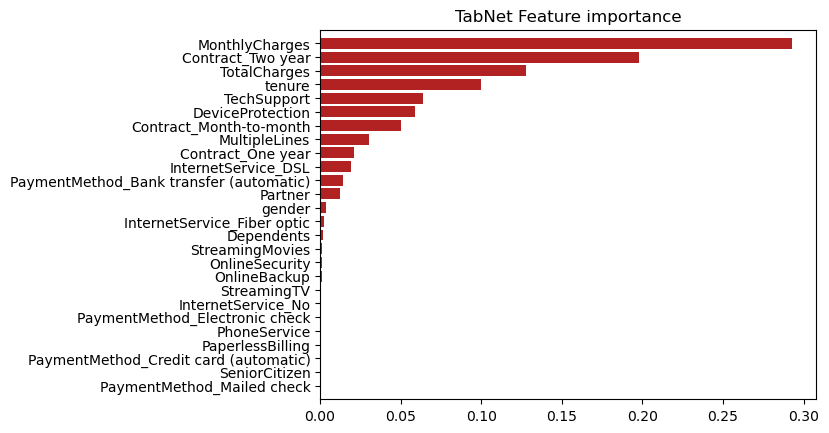

In [118]:
plt.figure()
plt.title("TabNet Feature importance")
plt.barh(range(len(tabnet_feature_importance)), tabnet_feature_importance[indices],
       color="firebrick", align="center")
plt.yticks(range(len(tabnet_feature_importance)), [X.columns[idx] for idx in indices])
plt.ylim([-1, len(tabnet_feature_importance)])
plt.show()

In [115]:
xgb_feature_importance = final_xgb_model.feature_importances_
indices = np.argsort(xgb_feature_importance)

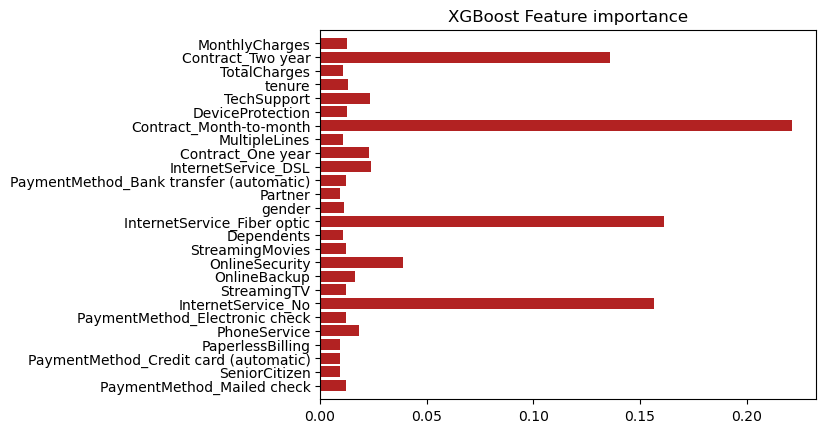

In [119]:
plt.figure()
plt.title("XGBoost Feature importance")
plt.barh(range(len(xgb_feature_importance)), xgb_feature_importance[indices],
       color="firebrick", align="center")
plt.yticks(range(len(xgb_feature_importance)), [X.columns[idx] for idx in indices])
plt.ylim([-1, len(xgb_feature_importance)])
plt.show()